# MLZC_HOMEWORK_WK4

## SETUP

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

print("✅ Libraries loaded\n")
print(f"Python version: {sys.version.split()[0]}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version:  {np.__version__}")
print(f"Seaborn version:  {sns.__version__}")
print(f"Matplotlib version:  {matplotlib.__version__}")

✅ Libraries loaded

Python version: 3.12.3
Pandas version: 2.3.2
NumPy version:  2.3.2
Seaborn version:  0.13.2
Matplotlib version:  3.10.6


## DATA

In [2]:
import urllib.request

url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
filename = 'course_lead_scoring.csv'

urllib.request.urlretrieve(url, filename)
print(f"✅ Downloaded: {filename}")

✅ Downloaded: course_lead_scoring.csv


In [4]:
df = pd.read_csv('course_lead_scoring.csv')

print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

df.head()

Shape: 1462 rows × 9 columns

Columns: ['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']

Data types:
lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

Missing values:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [5]:
df_copy = df.copy()

In [6]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [7]:
df_copy[categorical] = df_copy[categorical].fillna("NA")
df_copy[numerical] = df_copy[numerical].fillna(0.0)
    
print(df_copy.isnull().sum())

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64


## FRAMEWORK

In [8]:
df_full_train, df_test = train_test_split(df_copy, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [9]:
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")  
print(f"Test size: {len(df_test)}")
print(f"Total: {len(df_train) + len(df_val) + len(df_test)}")

print("Target distribution in training:")
print(f"Class 0: {(y_train == 0).sum()} ({(y_train == 0).mean():.3f})")
print(f"Class 1: {(y_train == 1).sum()} ({(y_train == 1).mean():.3f})")

print("Missing values in numerical columns:")
print(df_train[numerical].isnull().sum())
print("\nSample of data to verify 0.0 replacement:")
print(df_train[numerical].head(10))

temp_df = df_train[numerical].copy()
temp_df['converted'] = y_train
print("\nCorrelations with target:")
print(temp_df.corr()['converted'].sort_values(ascending=False))

Train size: 876
Validation size: 293
Test size: 293
Total: 1462
Target distribution in training:
Class 0: 332 (0.379)
Class 1: 544 (0.621)
Missing values in numerical columns:
number_of_courses_viewed    0
annual_income               0
interaction_count           0
lead_score                  0
dtype: int64

Sample of data to verify 0.0 replacement:
   number_of_courses_viewed  annual_income  interaction_count  lead_score
0                         2        95543.0                  3        0.78
1                         1        54924.0                  6        0.39
2                         2        77352.0                  2        0.22
3                         2        34600.0                  2        0.31
4                         0        43615.0                  2        0.01
5                         1        59090.0                  0        0.69
6                         1        23720.0                  1        0.02
7                         0        41832.0              

In [9]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

## ONE-HOT ENCODING

In [10]:
from sklearn.feature_extraction import DictVectorizer

In [11]:
dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts)

In [12]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

## TRAINING

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [23]:
y_pred = model.predict_proba(X_val)[:,1]
conversion = y_pred >= 0.5
round((y_val == conversion).mean(), 2)

np.float64(0.58)

In [24]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = conversion.astype(int)
df_pred['actual'] = y_val

df_pred

,probability,prediction,actual
0,0.979256,1,1
1,1.000000,1,1
2,1.000000,1,1
3,1.000000,1,0
4,1.000000,1,1
...,...,...,...
288,1.000000,1,1
289,0.999988,1,1
290,1.000000,1,1
291,1.000000,1,0


## QUESTIONS

In [16]:
# Q1: Which numerical variable (among the following 4) has the highest AUC?
for cat in numerical:
    roc_auc = roc_auc_score(y_train, df_train[cat])
    print(f"ROC AUC score for {cat} = {roc_auc}")


ROC AUC score for number_of_courses_viewed = 0.7635680590007088
ROC AUC score for annual_income = 0.5519578313253012
ROC AUC score for interaction_count = 0.738270176293409
ROC AUC score for lead_score = 0.6144993577250176


In [17]:
# Q2: What's the AUC of this model on the validation dataset? (round to 3 digits)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model.fit(X_train_scaled, y_train)
y_pred_scaled = model.predict_proba(X_val_scaled)[:,1]
roc_auc_scaled = roc_auc_score(y_val, y_pred_scaled)
round(roc_auc_scaled, 3)

0.921

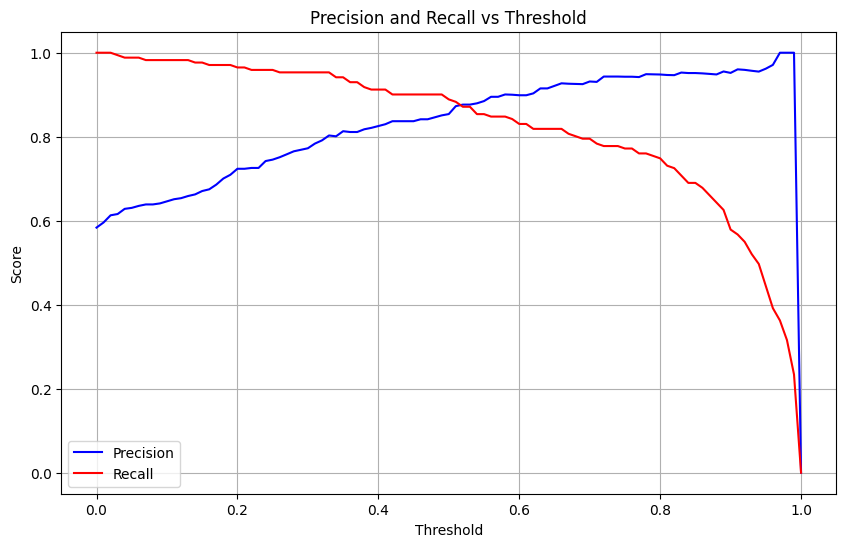

In [18]:
# Q3: At which threshold precision and recall curves intersect?
thresholds = np.linspace(0.0, 1.0, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred_scaled >= t)
    predict_negative = (y_pred_scaled < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if (tp + fp) > 0:
        p = tp / (tp + fp)
    else:
        p = 0
        
    if (tp + fn) > 0:
        r = tp / (tp + fn)
    else:
        r = 0
    
    scores.append((t, tp, fp, fn, tn, p, r))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores


thresholds_list = [score[0] for score in scores]
precision_list = [score[5] for score in scores]
recall_list = [score[6] for score in scores]

plt.figure(figsize=(10, 6))
plt.plot(thresholds_list, precision_list, label='Precision', color='blue')
plt.plot(thresholds_list, recall_list, label='Recall', color='red')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


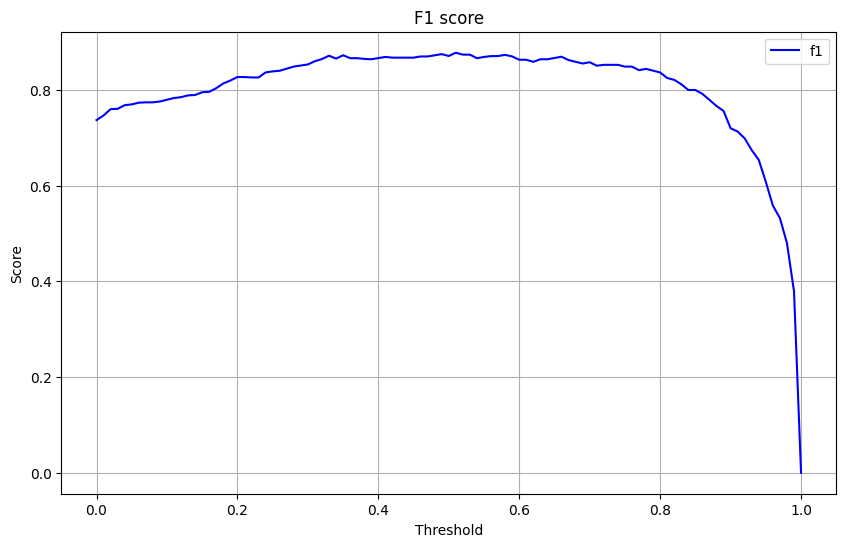

Maximum F1 score: 0.878
Threshold for maximum F1: 0.510


In [19]:
# Q4: At which threshold F1 is maximal?

thresholds = np.linspace(0.0, 1.0, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred_scaled >= t)
    predict_negative = (y_pred_scaled < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    if (tp + fp) > 0:
        p = tp / (tp + fp)
    else:
        p = 0
        
    if (tp + fn) > 0:
        r = tp / (tp + fn)
    else:
        r = 0
        
    if p + r == 0:
        f1 = 0
    else:
        f1 = 2 * ((p * r) / (p + r))
    
    scores.append((t, tp, fp, fn, tn, p, r, f1))
    
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

f1_list = [score[7] for score in scores]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_list, label='f1', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1 score')
plt.legend()
plt.grid(True)
plt.show()

f1_list = [score[7] for score in scores]
max_f1_idx = f1_list.index(max(f1_list))
max_f1_threshold = thresholds[max_f1_idx]
max_f1_value = f1_list[max_f1_idx]

print(f"Maximum F1 score: {max_f1_value:.3f}")
print(f"Threshold for maximum F1: {max_f1_threshold:.3f}")

In [20]:
# Q5: How large is standard deviation of the scores across different folds?
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train_scaled, y_train)
    
    return dv, scaler, model

def predict(df, dv, scaler, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    X_scaled = scaler.transform(X)
    y_pred = model.predict_proba(X_scaled)[:, 1]
    return y_pred

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]

    y_train_fold = df_train_fold.converted.values
    y_val_fold = df_val_fold.converted.values

    dv, scaler, model = train(df_train_fold, y_train_fold, C=1.0)
    y_pred = predict(df_val_fold, dv, scaler, model)

    auc = roc_auc_score(y_val_fold, y_pred)
    scores.append(auc)

print(f'C=1.0: {np.mean(scores):.3f} +- {np.std(scores):.3f}')
print(f'Standard deviation: {np.std(scores):.3f}')

0it [00:00, ?it/s]

C=1.0: 0.920 +- 0.010
Standard deviation: 0.010


In [21]:
# Q6: Which C leads to the best mean score?
C_values = [0.000001, 0.001, 1]

print("=== SCALED RESULTS ===")
for C in tqdm(C_values):
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]

        y_train_fold = df_train_fold.converted.values
        y_val_fold = df_val_fold.converted.values

        dv, scaler, model = train(df_train_fold, y_train_fold, C=C)
        y_pred = predict(df_val_fold, dv, scaler, model)

        auc = roc_auc_score(y_val_fold, y_pred)
        scores.append(auc)

    print(f'C={C}: {np.mean(scores):.3f} +- {np.std(scores):.3f}')

=== SCALED RESULTS ===


  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06: 0.907 +- 0.009
C=0.001: 0.911 +- 0.009
C=1: 0.920 +- 0.010
